## Modeling Discussion...

#### I have decided to use a fine-tuning approach, starting from the pre-trained BERT Transformer model, which is basically a bi-directional transformer model.  The BERT training objective mainly consists of taking input sentences, randomly masking some percentage of words (10-20%) and then predicting the masked words given the unmaksked words.  Specifically, I am starting with the pre-trained RoBERTa model, which is just a highly optimized version of BERT.  The authors replicated the BERT model, but trained it longer, on more data, and attempted to improve on some parameter choices.  

In [1]:
import os, sys
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import json
import random
from tqdm.notebook import tqdm
from tqdm import trange
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_processors as processors
from transformers import (
    RobertaConfig,RobertaModel,RobertaForSequenceClassification,RobertaTokenizer,
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = './data/'
data_full = data_dir + 'data_full.json'

MODEL_CLASSES = {
    "roberta": (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
}

## attribute dictionary (for convenience...)
class adict(dict):
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

In [3]:
## load full data set
with open(data_full, 'r') as f:
     data_dict = json.loads(f.read())

## select in-scope data
train_data = data_dict['train']
val_data = data_dict['val']
test_data = data_dict['test']

## extract unique labels...
labels = list(set([x[1] for x in val_data]))
labels.sort()

In [4]:
## ...and choose random 20 labels
num_labels = 20
data_seed = 67482531 ## random seed determines which 20 classes are chosen
random.seed(data_seed)
random.shuffle(labels)
labels = np.array(labels[:num_labels])
print('LABELS: {}'.format(labels))

LABELS: ['confirm_reservation' 'order_checks' 'min_payment' 'meal_suggestion'
 'thank_you' 'time' 'traffic' 'recipe' 'lost_luggage' 'vaccines'
 'calendar_update' 'nutrition_info' 'reset_settings' 'redeem_rewards'
 'what_song' 'definition' 'make_call' 'fun_fact' 'insurance'
 'schedule_meeting']


In [5]:
## filter data on 20 chosen labels
train_data = [x for x in train_data if x[1] in labels]
val_data = [x for x in val_data if x[1] in labels]
test_data = [x for x in test_data if x[1] in labels]

## make label dictionary
label_dict = {k: v for v, k in enumerate(labels)}

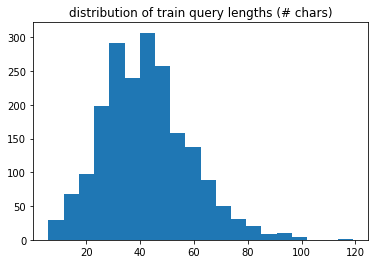

In [6]:
## plot distribution of query lengths (model uses max-length = 128)
q_lens = np.array([len(x[0]) for x in train_data])
plt.hist(q_lens, bins=20);
plt.title('distribution of train query lengths (# chars)')
plt.show()

In [7]:
## write data sets to tsv files
def save_data(file_name, queries, header='query\tlabel', path=None):
    fn = file_name if path is None else os.path.join(path, file_name)
    with open(fn, 'w') as f:
        if header is not None:
            f.write(header + '\n')
        for q in queries:
            f.write('{}\t{}\n'.format(q[0], label_dict[q[1]]))
save_data('train.tsv', train_data, path=data_dir)
save_data('val.tsv', val_data, path=data_dir)
save_data('test.tsv', test_data, path=data_dir)

In [8]:
def set_seeds(args):
    random.seed(args.model_seed)
    np.random.seed(args.model_seed)
    torch.manual_seed(args.model_seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.model_seed)

In [9]:
## Load data features from cache or dataset file
def load_examples(args, tokenizer, dataset='train', cache=True):
    processor = processors[args.task_name]() ## SST-2 Processor... a GLUE benchmark task for sentence classification
    output_mode = args.output_mode
    cached_features_file = os.path.join(
        args.data_dir,
        "cached_{}_{}_{}_{}".format(
            dataset,
            args.data_seed,
            list(filter(None, args.model_name_or_path.split("/"))).pop(),
            str(args.max_seq_length),
        ),
    )
    if cache and os.path.exists(cached_features_file) and not args.overwrite_cache:
        print("Loading features from cached file: {}".format(cached_features_file))
        features = torch.load(cached_features_file)
    else:
        print("Creating features from dataset file: {}".format(os.path.join(args.data_dir, '{}.tsv'.format(dataset))))
        if dataset=='train':
            examples = processor.get_train_examples(args.data_dir)
        elif dataset=='val':
            examples = processor._create_examples(processor._read_tsv(os.path.join(args.data_dir, 'val.tsv')), 'dev')
        else:
            examples = processor._create_examples(processor._read_tsv(os.path.join(args.data_dir, 'test.tsv')), 'dev')
        features = convert_examples_to_features(
            examples,
            tokenizer,
            label_list=args.label_list,
            max_length=args.max_seq_length,
            output_mode=output_mode,
            task=args.task_name,
        )
        if cache:
            print("Saving features into cached file: {}".format(cached_features_file))
            torch.save(features, cached_features_file)

    ## Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([0 for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset

In [10]:
## build parameter dict
args = adict()
args.batch_size = 32
args.model_type = 'roberta'
args.model_name_or_path = 'roberta-base'
args.data_dir = data_dir
args.data_seed = data_seed
args.max_seq_length = 128
args.model_seed = 1234
args.no_cuda = False
args.output_mode = 'classification'
args.overwrite_cache = False
args.task_name = 'sst-2' ## GLUE template for single sentence classification
device = torch.device('cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu')
if args.no_cuda:
    args.n_gpu = 0
    print('Not using gpu')
else:
    args.n_gpu = torch.cuda.device_count()
args.device = device
set_seeds(args)
args.label_list = list(map(str, range(num_labels)))

## Inspect Baseline Embeddings
#### By loading the baseline pre-trained Roberta model, and running a forward pass on our training queries, we can extract the initial embeddings of our queries from the hidden states, and basically "see" our queries the way the the pretrained Transformer model initially "sees" them.  After t-SNE dimension reduction, we can glimpse how "distinct" these 20 classes initially look to our pretrained model.  This may also give a good indication of how well our classifier might be able to perform after fine-tuning...

In [11]:
## load Roberta base model to view initial query embeddings
cfg = RobertaConfig.from_pretrained('roberta-base')
cfg.output_hidden_states = True
tok = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
mod = RobertaModel.from_pretrained('roberta-base', config=cfg)
mod.to(args.device)
mod.eval()

## load train data
dataset = load_examples(args, tok, dataset='train', cache=False)
sampler = SequentialSampler(dataset)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=args.batch_size)

Creating features from dataset file: ./data/train.tsv


In [12]:
## run forward pass of Roberta base model to obtain embeddings
X,Y = [],[]
for batch in dataloader:
    inputs, y = batch[0].to(args.device), batch[3]
    with torch.no_grad():
        outputs = mod(inputs)
    outputs = outputs[-1][0] ## extract query embeddings from hidden states
    outputs = torch.mean(outputs, dim=1).squeeze().detach().cpu().numpy() ## pool over tokens
    X.append(outputs)
    Y.append(y)
X,Y = np.vstack(X), np.hstack(Y)

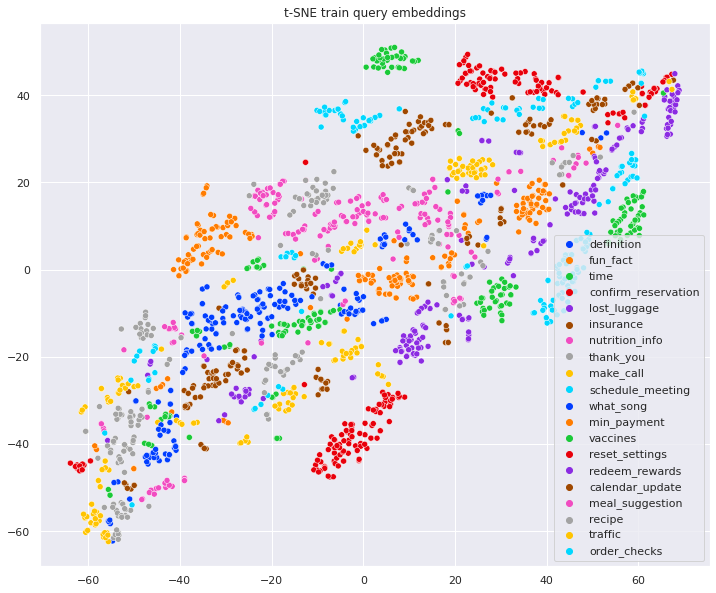

In [13]:
## use t-SNE (t-Distributed Stochastic Neighbor Embedding) to project 768-Dim query embeddings into 2-D space
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 10)})
palette = sns.color_palette("bright", num_labels)

tsne = TSNE()
X = tsne.fit_transform(X)
sns.scatterplot(X[:,0], X[:,1], hue=labels[Y], palette=palette)
plt.title('t-SNE train query embeddings')
plt.show()

#### ...so, from t-SNE 2-D projections of Roberta query embeddings, we can visually inspect and confirm that these 20 classes are reasonably distinct, without too much overlap.  WIth more time, this could be made more rigorous by employing some sort of class separation metric in the original 768 dimensions.  However, that might be overkill since simply attempting the classification (below) and measuring its performance serves the same purpose.

In [14]:
## clear memory
del mod, dataset, sampler, dataloader, X, Y

In [15]:
def evaluate(args, model, tokenizer, dataset='val'):
    results = {}
    eval_dataset = load_examples(args, tokenizer, dataset=dataset)
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.batch_size)
    eval_loss, nb_eval_steps = 0.0, 0
    preds, out_label_ids = None, None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)
        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]
            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)
    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)

    ## compute performance metrics...
    acc = { 'accuracy' : metrics.accuracy_score(out_label_ids, preds).round(4) }
    results.update(acc)
    print("{} set results -----------------".format(dataset).upper())
    print(metrics.classification_report(out_label_ids, preds, target_names=labels, digits=3))  
    return results

In [16]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.batch_size)
    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    ## Prepare optimizer and scheduler (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )
    
    print('')
    print("# epochs = {}".format(args.num_train_epochs))
    print("# train samples\t= {}".format(len(train_data)))
    print("# val samples\t= {}".format(len(val_data)))
    print("# test samples\t= {}".format(len(test_data)))
    print("\nBEGIN training...")
    
    global_step = 0
    epochs_trained = 0
    tr_loss = 0.0
    best_val_acc = 0
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=True,
    )
    
    ## Train loop...
    for e in train_iterator:
        print("\n============ EPOCH {} ============".format(e+1))
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]
            loss.backward()
            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                
        ## Evaluate...
        results = evaluate(args, model, tokenizer, dataset='val')
        if results['accuracy'] > best_val_acc:
            print("*** saving best model checkpoint to: {}".format(args.output_dir))
            best_val_acc = results['accuracy']
            model_to_save = (
                model.module if hasattr(model, "module") else model
            )
            model_to_save.save_pretrained(args.output_dir)
            tokenizer.save_pretrained(args.output_dir)
            torch.save(args, os.path.join(args.output_dir, "training_args.bin")) ## just to be safe...
    
    print("\n... END training\n")
    return global_step, tr_loss / global_step

In [17]:
## prepare training parameters
args.num_train_epochs = 5
args.learning_rate = 1e-05
args.output_dir = './best-model/'
args.adam_epsilon = 1e-08
args.do_lower_case = True
args.gradient_accumulation_steps = 1
args.max_grad_norm = 1.0
args.max_steps = -1
args.warmup_steps = 100
args.weight_decay = 0.0
print("\nTraining/evaluation parameters: {}\n".format(args))


Training/evaluation parameters: {'batch_size': 32, 'model_type': 'roberta', 'model_name_or_path': 'roberta-base', 'data_dir': './data/', 'data_seed': 67482531, 'max_seq_length': 128, 'model_seed': 1234, 'no_cuda': False, 'output_mode': 'classification', 'overwrite_cache': False, 'task_name': 'sst-2', 'n_gpu': 1, 'device': device(type='cuda'), 'label_list': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'], 'num_train_epochs': 5, 'learning_rate': 1e-05, 'output_dir': './best-model/', 'adam_epsilon': 1e-08, 'do_lower_case': True, 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 100, 'weight_decay': 0.0}



In [18]:
## load Roberta sequence classification model
config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
config = config_class.from_pretrained(
    args.model_name_or_path,
    num_labels=num_labels,
    finetuning_task=args.task_name,
)
tokenizer = tokenizer_class.from_pretrained(
    args.model_name_or_path,
    do_lower_case=args.do_lower_case,
)
model = model_class.from_pretrained(
    args.model_name_or_path,
    from_tf=bool(".ckpt" in args.model_name_or_path),
    config=config,
)
model.to(args.device);

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [19]:
## load training data
train_dataset = load_examples(args, tokenizer, dataset='train')

## do training...
train(args, train_dataset, model, tokenizer);

Creating features from dataset file: ./data/train.tsv
Saving features into cached file: ./data/cached_train_67482531_roberta-base_128

# epochs = 5
# train samples	= 2000
# val samples	= 400
# test samples	= 600

BEGIN training...

============ EPOCH 1 ============


Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

Creating features from dataset file: ./data/val.tsv
Saving features into cached file: ./data/cached_val_67482531_roberta-base_128


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

VAL SET RESULTS -----------------
                     precision    recall  f1-score   support

confirm_reservation      0.000     0.000     0.000        20
       order_checks      0.000     0.000     0.000        20
        min_payment      0.021     0.050     0.029        20
    meal_suggestion      0.000     0.000     0.000        20
          thank_you      0.000     0.000     0.000        20
               time      0.000     0.000     0.000        20
            traffic      1.000     0.050     0.095        20
             recipe      0.000     0.000     0.000        20
       lost_luggage      0.000     0.000     0.000        20
           vaccines      0.000     0.000     0.000        20
    calendar_update      0.000     0.000     0.000        20
     nutrition_info      0.000     0.000     0.000        20
     reset_settings      0.000     0.000     0.000        20
     redeem_rewards      0.000     0.000     0.000        20
          what_song      0.000     0.000     0.000

Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

Loading features from cached file: ./data/cached_val_67482531_roberta-base_128


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

VAL SET RESULTS -----------------
                     precision    recall  f1-score   support

confirm_reservation      1.000     1.000     1.000        20
       order_checks      1.000     0.900     0.947        20
        min_payment      1.000     1.000     1.000        20
    meal_suggestion      1.000     0.600     0.750        20
          thank_you      1.000     1.000     1.000        20
               time      1.000     1.000     1.000        20
            traffic      1.000     1.000     1.000        20
             recipe      0.556     1.000     0.714        20
       lost_luggage      1.000     1.000     1.000        20
           vaccines      1.000     1.000     1.000        20
    calendar_update      1.000     0.950     0.974        20
     nutrition_info      1.000     0.550     0.710        20
     reset_settings      1.000     1.000     1.000        20
     redeem_rewards      0.870     1.000     0.930        20
          what_song      1.000     1.000     1.000

Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

Loading features from cached file: ./data/cached_val_67482531_roberta-base_128


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

VAL SET RESULTS -----------------
                     precision    recall  f1-score   support

confirm_reservation      1.000     1.000     1.000        20
       order_checks      1.000     1.000     1.000        20
        min_payment      1.000     1.000     1.000        20
    meal_suggestion      1.000     0.950     0.974        20
          thank_you      1.000     1.000     1.000        20
               time      1.000     1.000     1.000        20
            traffic      1.000     1.000     1.000        20
             recipe      0.952     1.000     0.976        20
       lost_luggage      1.000     1.000     1.000        20
           vaccines      1.000     1.000     1.000        20
    calendar_update      1.000     0.950     0.974        20
     nutrition_info      1.000     0.950     0.974        20
     reset_settings      1.000     1.000     1.000        20
     redeem_rewards      1.000     1.000     1.000        20
          what_song      1.000     1.000     1.000

Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

Loading features from cached file: ./data/cached_val_67482531_roberta-base_128


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

VAL SET RESULTS -----------------
                     precision    recall  f1-score   support

confirm_reservation      1.000     1.000     1.000        20
       order_checks      1.000     1.000     1.000        20
        min_payment      1.000     1.000     1.000        20
    meal_suggestion      1.000     1.000     1.000        20
          thank_you      1.000     1.000     1.000        20
               time      1.000     1.000     1.000        20
            traffic      1.000     1.000     1.000        20
             recipe      1.000     1.000     1.000        20
       lost_luggage      1.000     1.000     1.000        20
           vaccines      1.000     1.000     1.000        20
    calendar_update      1.000     0.950     0.974        20
     nutrition_info      1.000     0.950     0.974        20
     reset_settings      1.000     1.000     1.000        20
     redeem_rewards      1.000     1.000     1.000        20
          what_song      1.000     1.000     1.000

Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

Loading features from cached file: ./data/cached_val_67482531_roberta-base_128


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

VAL SET RESULTS -----------------
                     precision    recall  f1-score   support

confirm_reservation      1.000     1.000     1.000        20
       order_checks      1.000     1.000     1.000        20
        min_payment      1.000     1.000     1.000        20
    meal_suggestion      1.000     1.000     1.000        20
          thank_you      1.000     1.000     1.000        20
               time      1.000     1.000     1.000        20
            traffic      1.000     1.000     1.000        20
             recipe      1.000     1.000     1.000        20
       lost_luggage      1.000     1.000     1.000        20
           vaccines      1.000     1.000     1.000        20
    calendar_update      1.000     0.950     0.974        20
     nutrition_info      1.000     0.950     0.974        20
     reset_settings      1.000     1.000     1.000        20
     redeem_rewards      1.000     1.000     1.000        20
          what_song      1.000     1.000     1.000

In [20]:
## Load best trained model and evaluate on test set
model = model_class.from_pretrained(args.output_dir)
model.to(args.device)
evaluate(args, model, tokenizer, dataset='test')

Creating features from dataset file: ./data/test.tsv
Saving features into cached file: ./data/cached_test_67482531_roberta-base_128


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

TEST SET RESULTS -----------------
                     precision    recall  f1-score   support

confirm_reservation      1.000     1.000     1.000        30
       order_checks      0.968     1.000     0.984        30
        min_payment      1.000     1.000     1.000        30
    meal_suggestion      0.967     0.967     0.967        30
          thank_you      1.000     0.967     0.983        30
               time      1.000     1.000     1.000        30
            traffic      1.000     1.000     1.000        30
             recipe      0.967     0.967     0.967        30
       lost_luggage      1.000     1.000     1.000        30
           vaccines      1.000     1.000     1.000        30
    calendar_update      1.000     0.967     0.983        30
     nutrition_info      1.000     1.000     1.000        30
     reset_settings      1.000     1.000     1.000        30
     redeem_rewards      1.000     1.000     1.000        30
          what_song      1.000     1.000     1.00

{'accuracy': 0.9933}